# Project 1 DLAD
### Sensor
Velodyne HDL-64E S3
* Channels: 64
* FoV Vertical : from -24.9 to 2 degrees

### Naming scheme:
* X is a 3d point
* x is a 2d point
* Xh is a 3d homogeneous point
* xh is a 2d homogeneous point



## Exercise 1

In [ ]:
import os
from load_data import load_data
import numpy as np
import matplotlib.pyplot as plt

#Loading the dictionary
data_path = os.path.join('data/','data.p')
data = load_data(data_path)

#Taking the required data from the dictionary
velodyne = data.get('velodyne')
X = velodyne[:,0]
Y = velodyne[:,1]
alpha = velodyne[:,3]
xyz = np.zeros((np.size(X),3))
xyz[:,0] = X
xyz[:,1] = Y
xyz[:,2] = alpha

#Finding the min, max of the coordinates and the no. of pixels to be used later for temperory arrays
X_max = np.max(X)
Y_max = np.max(Y)
X_min = np.min(X)
Y_min = np.min(Y)
no_pix_x = int((X_max - X_min)/0.2)
no_pix_y = int((Y_max - Y_min)/0.2)

#Creating a temperary array to create the required resolution grid and filter coinciding points in the same grid
l = np.size(X)
xyz_filt1 = np.zeros((no_pix_x*no_pix_y,3))
a = 0
while a < l:
    n = int((xyz[a,0]- X_min)/0.2)
    m = int((xyz[a,1]- Y_min)/0.2)
    if xyz[a,2] >= xyz_filt1[n*m,2]:
        xyz_filt1[n*m,:] = xyz[a,:]
    a = a + 1

#Removing the rows with no data. Second filtering to get final array
a = 0
b = 0
xyz_filt2 = np.zeros((np.size(X),3))
while a < len(xyz_filt1):
    if xyz_filt1[a,0] != 0 or xyz_filt1[a,1] != 0:
        xyz_filt2[b,:] = xyz_filt1[a,:]
        b = b + 1
    a = a + 1

#Plot using scatter plot with black background 
plt.style.use('dark_background')
plt.scatter(xyz_filt2[:,0], xyz_filt2[:,1],  c = xyz_filt2[:,2], s = 0.02, cmap = 'Greys')
plt.show()

#End of code


## Exercise 2

In [ ]:
import os
from load_data import load_data
import numpy as np
import matplotlib.pyplot as plt

#Loading data
data_path = os.path.join('data/','data.p')
data = load_data(data_path)

#Getting the required data from the dictionary into seperate data sets
velodyne = data.get('velodyne')
cam2_image = data.get('image_2')
p_r20 = data.get('P_rect_20')
t_c2v = data.get('T_cam0_velo')
sem_label = data.get('sem_label')
color_map = data.get('color_map')
bbox = data.get('objects')

#Filtering the velodyne data to get only the front part of the scan
X = velodyne[:,0]
a = 0
b = 0
velodyne_filt = np.zeros((np.size(X),4))
c2_color = np.zeros((np.size(X),3))

while a < np.size(X):
    if velodyne[a,0] > 0:
        velodyne_filt[b,:] = velodyne[a,:]
        c2_color[b,:] = color_map.get(sem_label[a,0])
        b = b + 1
    a = a + 1

velodyne_filt1 = velodyne_filt[:b,:]
c2_color1 = c2_color[:b,:]
velodyne_filt1[:,3] = 1

#Transforming the point cloud to camera coordinates
c0_points = np.dot(t_c2v,velodyne_filt1.T)
c2_points = np.dot(p_r20,c0_points).T
norm = c2_points[:,2:]
c2_points = c2_points/norm

#Changing BGR to RGB
R_c = c2_color1[:,2]
G_c = c2_color1[:,1]
B_c = c2_color1[:,0]
c2_color1[:,0] = R_c
c2_color1[:,1] = G_c
c2_color1[:,2] = B_c

#To get the edge points in the camera 2 coordinates after correcting the rotation
rot_y = np.zeros((3,3))
edge = np.zeros((len(bbox),8,4))
a = 0
while a < len(bbox):
    c = bbox[a]
    x = c[11]
    y = c[12]
    z = c[13]
    h = c[8]
    l = c[9]
    w = c[10]
    r = c[14]
    rot_y[0,0] = np.cos(r)
    rot_y[0,2] = np.sin(r)
    rot_y[1,1] = 1
    rot_y[2,0] = -1*np.sin(r)
    rot_y[2,2] = np.cos(r)
    check = np.dot(rot_y,np.array([w/2,-h,l/2])) + np.array([x,y,z])
    edge[a,0,:3] = np.dot(rot_y,np.array([w/2,-h,l/2])) + np.array([x,y,z])
    edge[a,1,:3] = np.dot(rot_y,np.array([-w/2,-h,l/2])) + np.array([x,y,z])
    edge[a,2,:3] = np.dot(rot_y,np.array([-w/2,-h,-l/2])) + np.array([x,y,z])
    edge[a,3,:3] = np.dot(rot_y,np.array([w/2,-h,-l/2])) + np.array([x,y,z])
    edge[a,4,:3] = np.dot(rot_y,np.array([w/2,0,l/2])) + np.array([x,y,z])
    edge[a,5,:3] = np.dot(rot_y,np.array([-w/2,0,l/2])) + np.array([x,y,z])
    edge[a,6,:3] = np.dot(rot_y,np.array([-w/2,0,-l/2])) + np.array([x,y,z])
    edge[a,7,:3] = np.dot(rot_y,np.array([w/2,0,-l/2])) + np.array([x,y,z])
    a = a + 1

edge[:,:,3] = 1

#Defining the connect vector used to create the bounding box
connect = np.asarray([[0,1],[0,3],[0,4],
                                   [2,1],[2,3],[2,6],
                                   [5,1],[5,4],[5,6],
                                   [7,3],[7,4],[7,6]])


#Plotting the coloured point cloud, the bounding box and the camera 2 image in the same plot
plt.scatter(c2_points[:b,0],c2_points[:b,1],c = c2_color1[:b,:]/255, s = 0.2)
b = 0
while b < len(bbox):
    a = 0
    ed_points = np.dot(p_r20,edge[b,:,:].T).T
    norm1 = ed_points[:,2:]
    ed_points = ed_points/norm1
    while a < np.size(connect[:,0]):
        plt.plot([ed_points[connect[a,0],0],ed_points[connect[a,1],0]],[ed_points[connect[a,0],1],ed_points[connect[a,1],1]], color = 'green', linewidth = 2)
        a = a + 1
    b = b + 1
plt.imshow(cam2_image)
plt.show()

#End of code


## Exercise 3
Identify individual channels. Channels are laser beams at different elevation angles that give rise to vertical resolution.
Apparently they are formed by different wavelength beams.

In [2]:
from load_data import load_data
from data_utils import *
import numpy as np
import cv2 as cv
import PIL.Image
from PIL import Image
from IPython.display import clear_output, Image, display
import io

# https://stackoverflow.com/questions/34643747/ipython-notebook-jupyter-opencv-cv2-and-plotting
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [10]:
data_dict = load_data('data/data.p')
print('Velodyne')
print('----------')
print('Head')
print(data_dict['velodyne'][0:5])
print('Shape')
print(data_dict['velodyne'].shape)

Velodyne
----------
Head
[[75.44401    6.459378   2.7706459  0.       ]
 [75.16147    6.673324   2.7616658  0.       ]
 [75.483376   7.180198   2.7747202  0.       ]
 [75.96583    7.467128   2.7917533  0.       ]
 [67.056274   6.801266   2.489618   0.       ]]
Shape
(119454, 4)


In [11]:
velodyne = data_dict['velodyne']
velodyne_r = np.sqrt(np.sum(np.square(velodyne), axis = 1))
velodyne_angle = 180 / np.pi * np.arcsin(velodyne[:,2]/velodyne_r).reshape(-1,1)
# velodyne angle only correct for points that lie infront of lidar (i.e. x>0),
# but these are also the only points captured by image

In [28]:
FoV_vertical_min = -24.9
FoV_vertical_max = 2
FoV_vertical = FoV_vertical_max - FoV_vertical_min
angular_res_vert = FoV_vertical/64
channel = (velodyne_angle - FoV_vertical_min)/angular_res_vert
color = np.mod(channel, 4)
color = np.round(color, 0)

# project the 3d homogeneous points (Lidar coordinates) to 3d homogeneous points (cam0 coordinates)
Xh_velodyne = np.copy(velodyne)
Xh_velodyne[:, 3] = 1

# project from velodyne to cam0
Xh_rectified_cam0 = np.matmul(data_dict['T_cam0_velo'] , np.transpose(Xh_velodyne))

# Get rid of points behind cam
indices = np.where(Xh_rectified_cam0[2, :] >= 0)[0]
Xh_rectified_cam0 = Xh_rectified_cam0[:, indices]
color = color[indices]

# project the 3d homogeneous points to 2d homogeneous points on the rectified cam2 image plane
xh_rectified_cam2 = np.matmul(data_dict['P_rect_20'], Xh_rectified_cam0)

# normalize such that homogeneous coordinate is 1.0 again
xh_rectified_cam2 = xh_rectified_cam2 / xh_rectified_cam2[2,:]

# prune homogeneous coordinates
x_rectified_cam2 = xh_rectified_cam2[0:2]

# convert float32 -> int32 (implicit rounding)
x_rectified_cam2 = x_rectified_cam2.astype(np.int32)

#  2nd index goes ove image dimensions
x_rectified_cam2 = np.transpose(x_rectified_cam2)

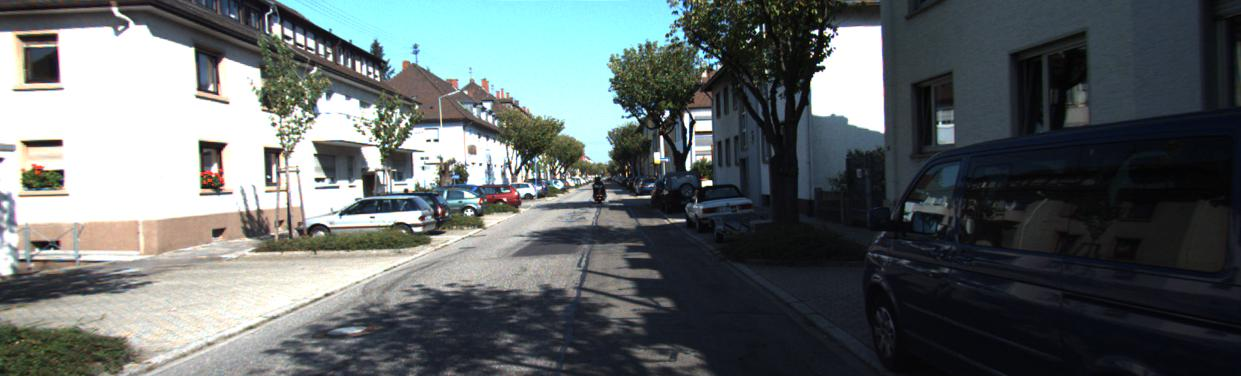

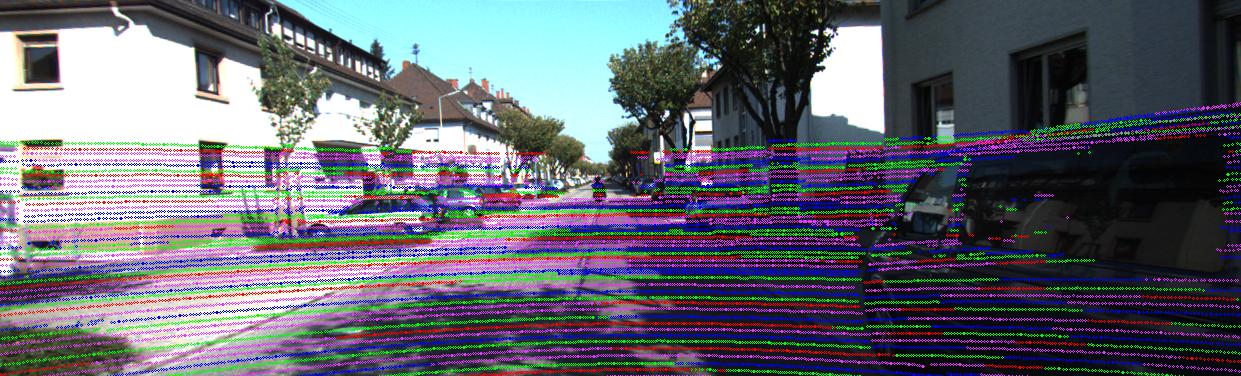

In [29]:
image_2 = data_dict["image_2"]
image_2_laser_id = np.copy(image_2)

for i in range(np.shape(x_rectified_cam2)[0]) :
    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    
    if color[i] == 0:
        c = (255, 0, 0)
    elif color[i] == 1:
        c = (0, 255, 0)
    elif color[i] == 2:
        c = (0, 0, 255)
    else:
        c = (230, 55, 255)
        
    cv.circle(img = image_2_laser_id, center = (x,y), radius = 1, color = c)

plt.imsave("image_2.png", image_2.astype(np.uint8))
showarray(image_2)
plt.imsave("image_2_laser_id.png", image_2_laser_id.astype(np.uint8))
showarray(image_2_laser_id)

## Exercise 4
Removing motion distortion

In [115]:
# Calib data
cam2cam = calib_cam2cam('data/problem_4/calib_cam_to_cam.txt', mode = '02')
velo2cam = calib_velo2cam('data/problem_4/calib_velo_to_cam.txt')

# transformation matrix from velodyne to cam0 3d
T = np.append(velo2cam[0], velo2cam[1], axis=1)
T = np.append(T, [[0,0,0,1]], axis = 0)

imu2velo = calib_velo2cam('data/problem_4/calib_imu_to_velo.txt')
imu2velo = np.append(imu2velo[0], imu2velo[1], axis=1)
imu2velo = np.append(imu2velo, [[0,0,0,1]], axis = 0)

velo2imu = np.linalg.inv(imu2velo)


def transform2cam(point_cloud, T):
    
    # cam0 3d coordinates
    Xh_cam0 = np.matmul(T, point_cloud.T)
    
    # here eliminate points in the back
    indices = np.where(Xh_cam0[2,:] > 0)[0]
    Xh_cam0 = Xh_cam0[:, indices]

    # cam2 to image plane
    cam2coord2d = np.matmul(cam2cam, Xh_cam0)
    cam2coord2d = cam2coord2d / cam2coord2d[2, :]
    cam2coord2d = cam2coord2d[:2,:]

    distances = np.sqrt(np.sum(np.square(Xh_cam0), axis = 0))
    colormap = depth_color(distances)
    
    return cam2coord2d, colormap


def removeMotionDistortion(index):
    
    # read all the required data
    image = cv.imread('data/problem_4/image_02/data/' + index + '.png', )
    point_cloud = load_from_bin('data/problem_4/velodyne_points/data/' + index + '.bin')[:,:4]
    lidar_t_start = compute_timestamps('data/problem_4/velodyne_points/timestamps_start.txt', index)
    lidar_t_trigger = compute_timestamps('data/problem_4/velodyne_points/timestamps.txt', index)
    # lidar_t_trigger = compute_timestamps('data/problem_4/image_02/timestamps.txt', index)
    lidar_t_end = compute_timestamps('data/problem_4/velodyne_points/timestamps_end.txt', index)
    v = load_oxts_velocity('data/problem_4/oxts/data/' + index + '.txt')
    angular_rate = np.asarray(load_oxts_angular_rate('data/problem_4/oxts/data/' + index + '.txt'))
    angular_rate_z = angular_rate[2]
    
    # Angle of LiDAR sensor with respect to starting position (clockwise)
    trigger_angle = (lidar_t_trigger - lidar_t_start) / (lidar_t_end - lidar_t_start) * 360
    # Always 180. LiDAR starts from behind and rotates cw.

    # compute angle for each point in degree
    angles = np.arctan2(point_cloud[:,1], point_cloud[:,0])
    angles = (180 / np.pi * angles) 
    
    # Due to properties of arctan2 there are negative values on right, which we convert to positive
    indices = np.where(angles < 0)[0]
    angles[indices] += 360
    
    # Angles in rad with respect to camera trigger. Add and modulo are for the possibility of having angle = 360
    angles_relative = (angles + 360 - trigger_angle) % 360
    angles_relative = np.pi * angles_relative / 180
    print(angles)
    
    # time stamp of individual lasers
    timestamp_laser = lidar_t_start + (lidar_t_end - lidar_t_start) * (angles_relative / (2*np.pi))
    timestamp_laser2trigger = timestamp_laser - lidar_t_trigger

    # Convert to homogeneous coordinates
    point_cloud = np.append(point_cloud, np.ones((len(point_cloud), 1)), axis=1 )
    point_cloud_original = np.copy(point_cloud)
    
    # Convert to IMU coordinates
    point_cloud = np.matmul(velo2imu, point_cloud.T).T
    
    # now iterate over the points and correct them
    for i in range(len(point_cloud)):
        translation = timestamp_laser2trigger[i] * v
        # translation = np.zeros(v.shape)
        angle = -timestamp_laser2trigger[i] * angular_rate_z
        R = np.array([[np.cos(-angle), -np.sin(-angle), 0],
                     [np.sin(-angle), np.cos(-angle), 0],
                     [0,0,1]
                     ])
        # R = np.identity(3)
        M = np.append(R, -translation.reshape(-1,1), axis = 1)
        M = np.append(M, [[0,0,0,1]], axis=0)

        point_cloud[i,:] = np.matmul(M, point_cloud[i, :].T).T

    # Transform back to Lidar coordinates
    point_cloud = np.matmul(imu2velo, point_cloud.T).T
    
    # Project to cam coordinates
    cam2coord2d, colormap = transform2cam(point_cloud, T)
    cam2coord2d_distortion, colormap_distortion = transform2cam(point_cloud_original, T)

    image2 = np.copy(image)
    image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
    showarray(image2)
    
    image_distortion = print_projection_plt(cam2coord2d_distortion, colormap_distortion, image.astype(np.uint8))
    plt.imsave("image_" + index + "distortion" +  ".png", image_distortion)
    showarray(image_distortion)
    
    image_distortion_removed = print_projection_plt(cam2coord2d, colormap, image)
    plt.imsave("image_" + index + "distortion_corrected" +  ".png", image_distortion_removed.astype(np.uint8))
    showarray(image_distortion_removed)

[ 13.084826  13.264707  13.444375 ... 344.9314   345.02045  345.19836 ]
[1.12495925e-02 1.02006398e-01 2.85036743e-01 ... 3.39299927e+02
 3.39476959e+02 3.39652802e+02]
[1.7352617e-01 3.5330737e-01 5.3579700e-01 ... 3.3938248e+02 3.3955322e+02
 3.3973639e+02]


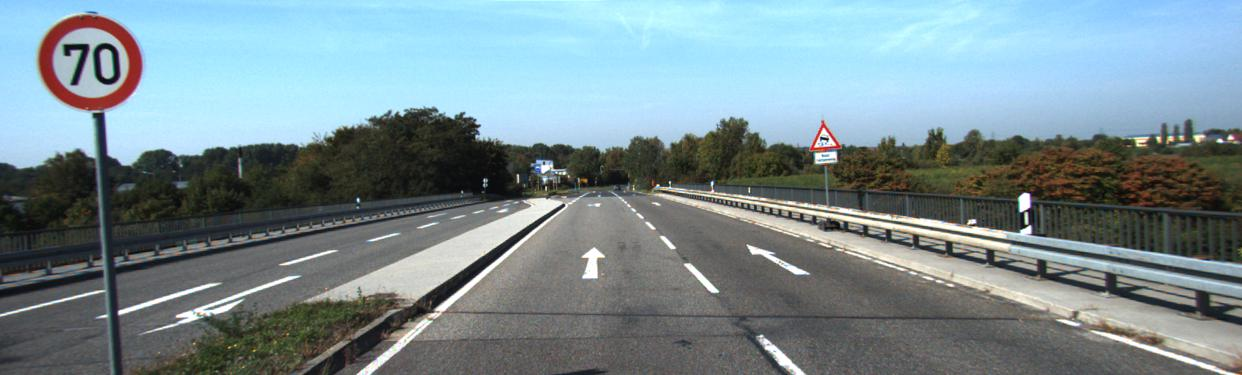

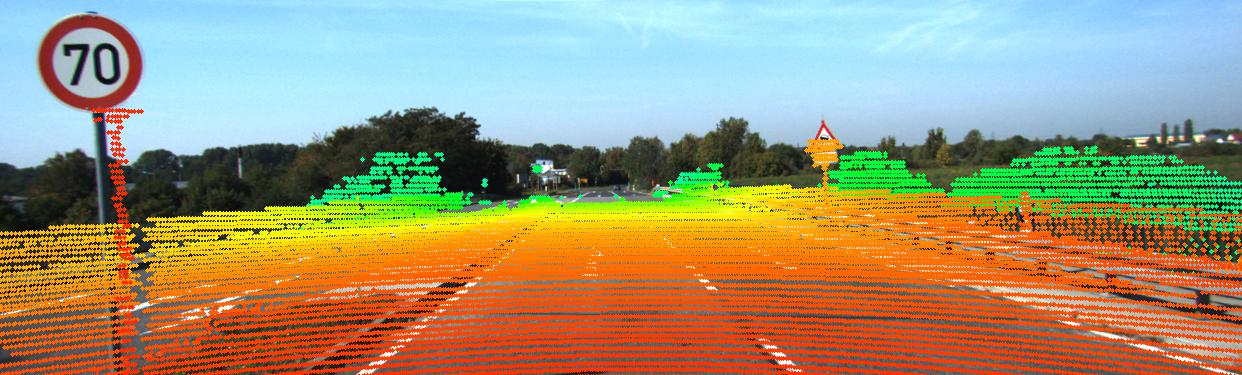

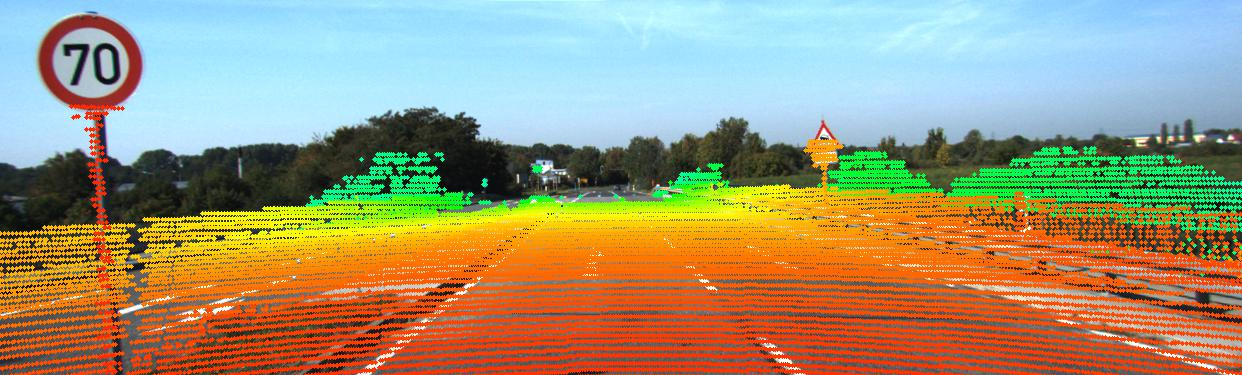

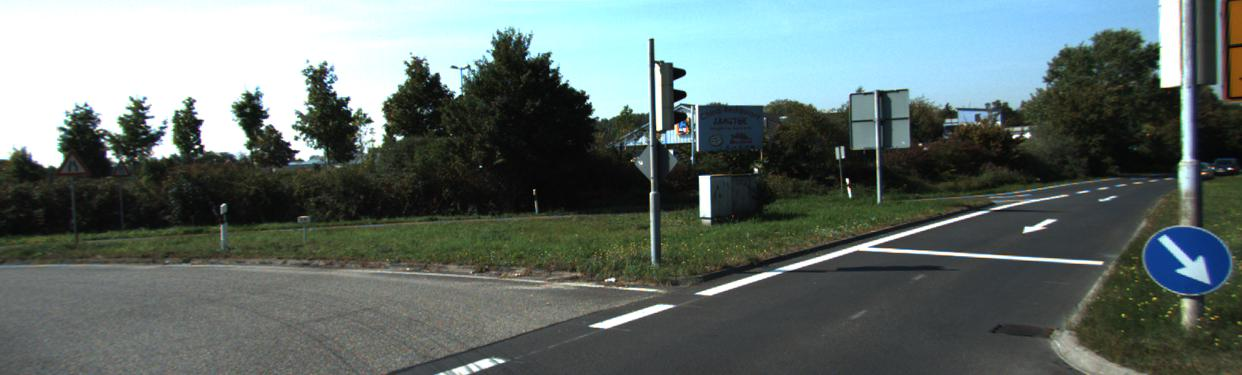

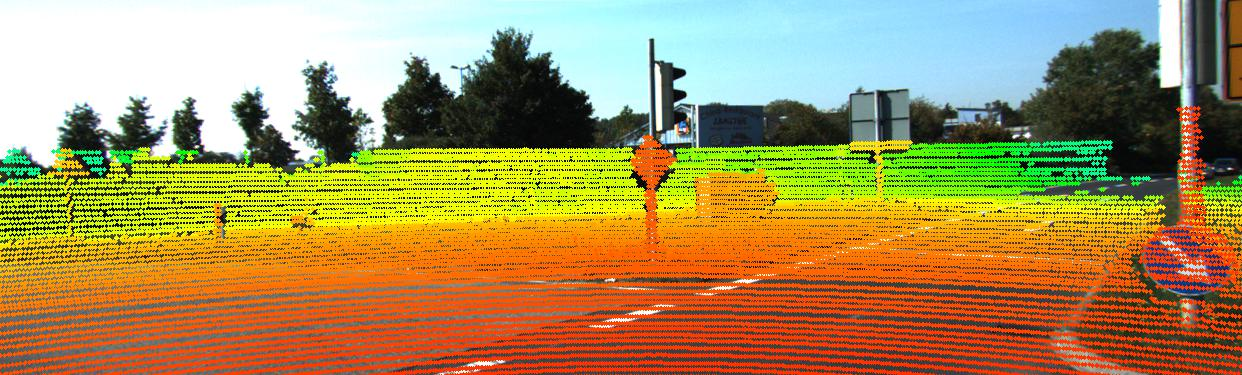

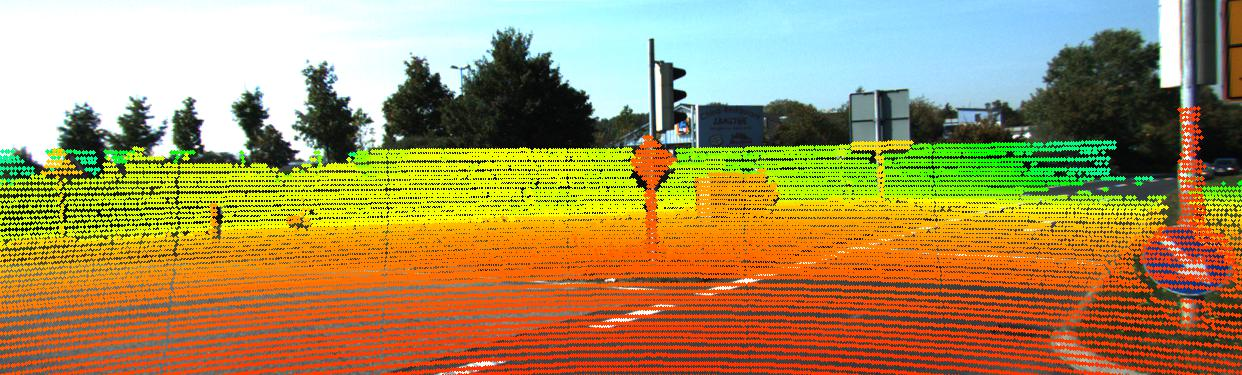

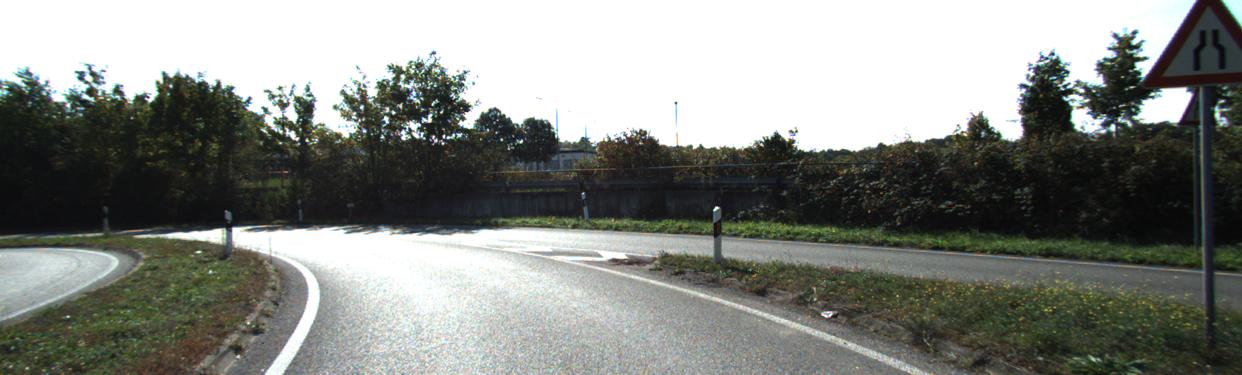

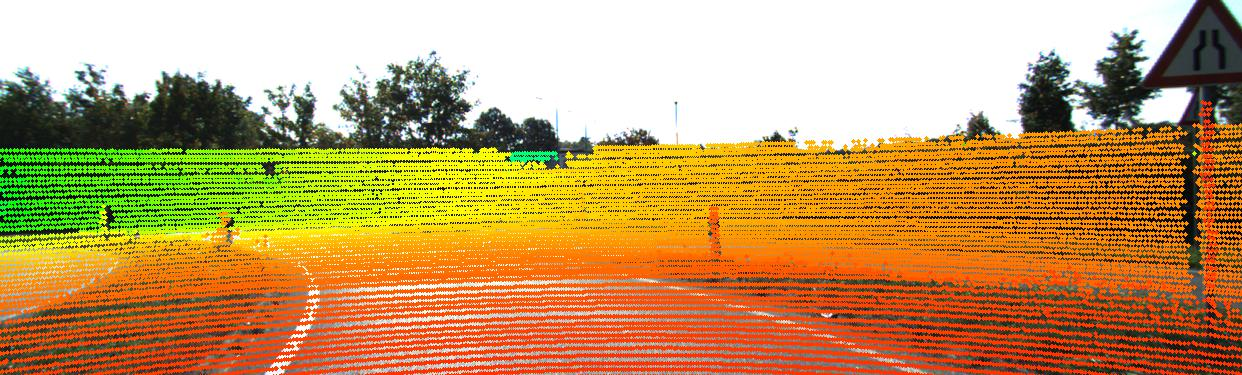

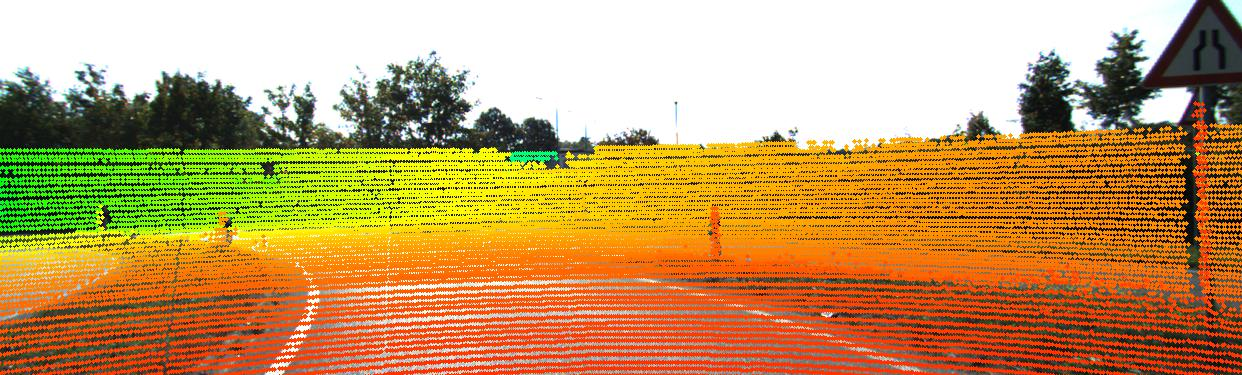

In [116]:
indecies = ['0000000037', '0000000312', '0000000340']
for i in range(3):
    removeMotionDistortion(indecies[i])

